Kaggle dataset: https://www.kaggle.com/code/jatingoyal123/hate-offensive-language

In [176]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Extend the display width 
pd.options.display.max_colwidth = 100


In [177]:
pd.read_csv('./data/labeled_data.csv').head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...


First we clean the dataframe by removing the unnecessary columns that map to 'class' column which tells us what type the tweet is. We also get rid of the duplicated id column.

In [200]:
# Read csv file
df_tweets = pd.read_csv('./data/labeled_data.csv')

# Copy the df before changing it
df_original_tweets = df_tweets.copy()

# Create a dictionary to map the labels to numbers
label_dict = {0: 'Hate speech', 1: 'Offensive language',2: 'Neither'}

# Drop the columns we don't need
df_tweets = df_tweets.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# Rename the columns
df_tweets = df_tweets.rename(columns={'tweet': 'text', 'class.1': 'label'})

print(f"Shape of the dataframe: {df_tweets.shape}")

Shape of the dataframe: (24783, 2)


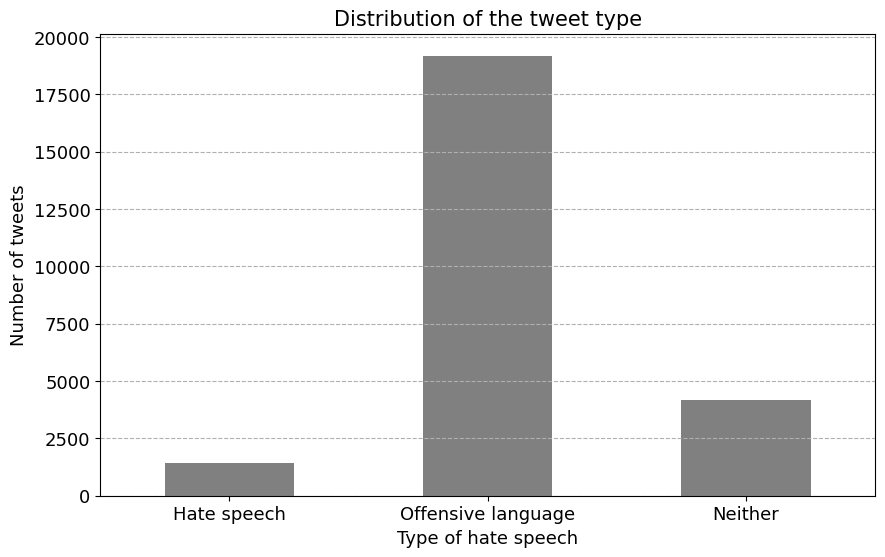

In [179]:
# Plot the distribution of the class column and sort the values
ax = df_tweets['class'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color='gray', fontsize=13)

# Get current ax tics 
ax_tics = ax.get_xticks()

# Add the title and labels
ax.set_title('Distribution of the tweet type', fontsize=15)
ax.set_ylabel('Number of tweets', fontsize=13)
ax.set_xlabel('Type of hate speech', fontsize=13)

# Add grid lines
ax.grid(axis='y', linestyle='--')


# Set the xticts with the class names
ax.set_xticklabels([label_dict[i] for i in range(3)], rotation=0)

# Save the plot into slike folder
plt.savefig('./slike/distribution-bar.png')


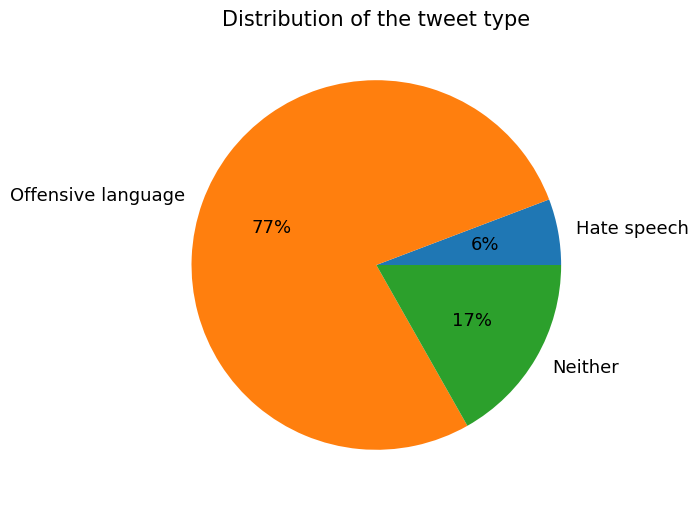

In [259]:
# Plot a pie chart of the classess by using labels from label_dict
df_tweets['class'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%', labels=[label_dict[i] for i in range(3)], figsize=(10, 6), fontsize=13)


# Label the pie chart
plt.ylabel('')
plt.title('Distribution of the tweet type', fontsize=15)


# Save the plot into slike folder
plt.savefig('./slike/distribution-pie.png')


In [181]:
# Print the distribution of classes
print(df_tweets['class'].value_counts().sort_index())

0     1430
1    19190
2     4163
Name: class, dtype: int64


For the sake of classification we will join hate with offensive speech into a single class. We will also move the 'neither' class from 2 to 0, for easier usage later.

In [182]:
# Join the hate speech and offensive language classes
df_tweets['class'] = df_tweets['class'].replace(0, 1)
# Move the class 2 to class 0
df_tweets['class'] = df_tweets['class'].replace(2, 0)

# Delete the item where class is 0 from label_dicŽt
label_dict[0] = label_dict[2]
del label_dict[2]

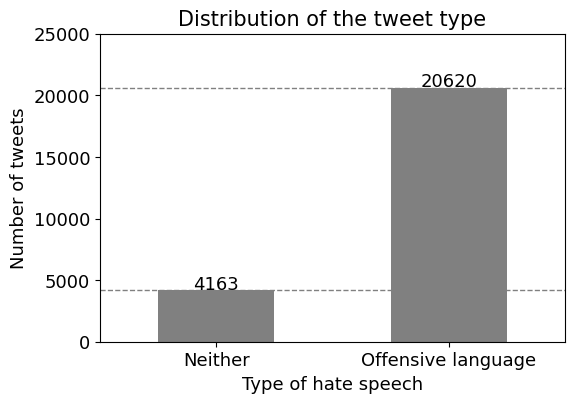

In [183]:
# Plot the distribution of the class column and sort the values
ax = df_tweets['class'].value_counts().sort_index().plot(kind='bar', figsize=(6, 4), color='gray', fontsize=13)

# Get current ax tics 
ax_tics = ax.get_xticks()

# Add the title and labels
ax.set_title('Distribution of the tweet type', fontsize=15)
ax.set_ylabel('Number of tweets', fontsize=13)
ax.set_xlabel('Type of hate speech', fontsize=13)


# Set the yticks 
ax.set_yticks([5000 * i for i in range(6)])

# Create horizontal lines for both values of the class column
for i in range(2):
    ax.axhline(df_tweets['class'].value_counts().sort_index()[i], color='gray', linestyle='dashed', linewidth=1)
    # Add the value on the line
    ax.text(ax_tics[i], df_tweets['class'].value_counts().sort_index()[i] + 100, df_tweets['class'].value_counts().sort_index()[i], fontsize=13, ha='center')
    

# Set the xticts with the class names
_=ax.set_xticklabels([label_dict[i] for i in range(2)], rotation=0)

# Save plt
plt.savefig('./slike/distribution-merged-bar.png')

Now we clean the tweets by transforming and normalizing them

In [184]:
import re
import nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joksz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [185]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    text = text.replace('rt', '')

    # Remove the @name from the text
    text = re.sub('@[^\s]+','',text)
    

    return text

In [186]:
# Apply the clean_text function to the text column
df_tweets['text'] = df_tweets['text'].apply(clean_text)

In [187]:
from wordcloud import WordCloud, STOPWORDS

In [188]:
def make_wordcloud(df, saveplot=False):
    tweet_words=""
    for val in df.text: 
        val = str(val).lower()

      
        tweet_words += val
        
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words(),min_font_size = 10)
    
    wordcloud.generate(tweet_words)

    plt.figure(figsize = (10, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    # Save the plot
    if saveplot:
        plt.savefig(saveplot)

    plt.show()


Offensive language


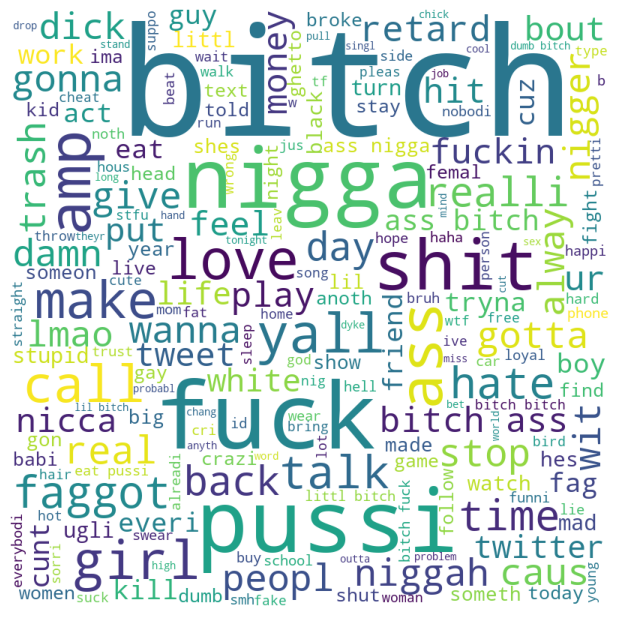

Language not labeled as offensive


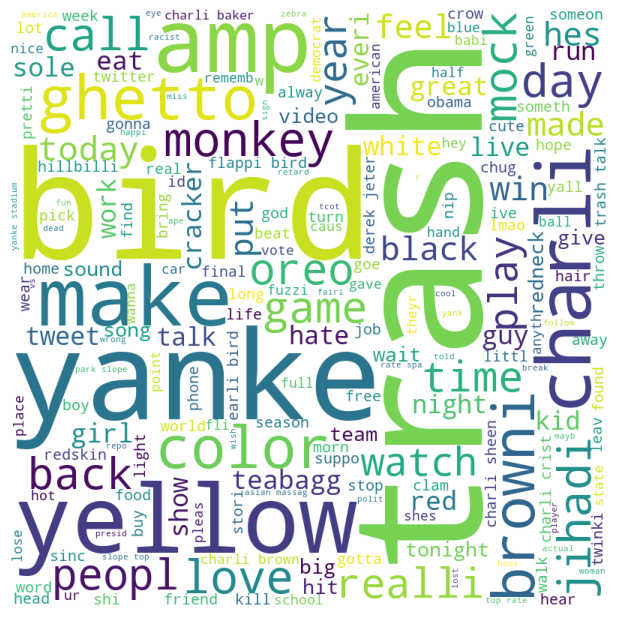

In [189]:
print("Offensive language")
#make_wordcloud(df_tweets[df_tweets['class']==1])

print("Language not labeled as offensive")
make_wordcloud(df_tweets[df_tweets['class']==0], saveplot='./slike/wordcloud-base')

In [190]:
x=df_tweets['text']
y=df_tweets['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [191]:
count = CountVectorizer(stop_words='english', ngram_range=(1,5))
x_train_vectorizer=count.fit_transform(x_train)

In [192]:
x_test_vectorizer=count.transform(x_test)

In [193]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [194]:
model_vectorizer= MultinomialNB().fit(x_train_vectorizer, y_train)
prediction_vectorizer=model_vectorizer.predict(x_test_vectorizer)

conf = confusion_matrix(y_test, prediction_vectorizer)

conf_matrix_df = pd.DataFrame(conf, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
conf_matrix_df.style.background_gradient(cmap='Blues')
print(conf_matrix_df)


print (classification_report(y_test, prediction_vectorizer))

        Pred 0  Pred 1
True 0     352     689
True 1      21    5134
              precision    recall  f1-score   support

           0       0.94      0.34      0.50      1041
           1       0.88      1.00      0.94      5155

    accuracy                           0.89      6196
   macro avg       0.91      0.67      0.72      6196
weighted avg       0.89      0.89      0.86      6196



In [195]:
import xgboost as xgb
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

C:\Users\joksz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [196]:
xgb_model_vectorizer = xgb_model.fit(x_train_vectorizer, y_train)
xgb_predictions_vectorizer=xgb_model_vectorizer.predict(x_test_vectorizer)
conf = confusion_matrix(y_test,xgb_predictions_vectorizer)

conf_matrix_df = pd.DataFrame(conf, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
conf_matrix_df.style.background_gradient(cmap='Blues')
print(conf_matrix_df)
print (classification_report(y_test, xgb_predictions_vectorizer))

        Pred 0  Pred 1
True 0     993      48
True 1     358    4797
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1041
           1       0.99      0.93      0.96      5155

    accuracy                           0.93      6196
   macro avg       0.86      0.94      0.89      6196
weighted avg       0.95      0.93      0.94      6196



In [211]:
# Get indexes of false positives
fp_indexes = [i for i in range(len(xgb_predictions_vectorizer)) if xgb_predictions_vectorizer[i] == 1 and y_test.iloc[i] == 0]

for i in fp_indexes:
    print(df_original_tweets.iloc[i]['tweet'])

!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
"@BeEasyJrizzy: u ever kill a ant on the sidewalk and think damn what if that nigga was on his way to get some pussy"No bs must b &gt;30%chance
"@Johnny55Perez: @white_thunduh ha well iguess I make them hoes loyal bro" theyll never be loyal that y they hoes my nig
"@KissMySmilee: Don't got time for bitches to be actin iffy."
"@ambitiousBree: @_1nonlykeisha u see the damn phone ringing? &#128547;&#128530;&#128542;" when you married bitches makes demands!!!! You haven't called me
&#128149;&#128149;&#128149; pussy ride dick like she a Jamaican / \ / &#128167;\ 
. */. &#127796; |. &#165;~ ! &#127796;. | &gt; \ 
&#128043; $. / &#127806;\ ; &#128043; ) &amp;&#128043;*
&#8220;@BlueEyeBeaner: Vienna sausage clit http://t.co/YY1Gj6oeds&#8221; 

I suck dat bitch. Don&#8217;t y&#8217;all eva believe a colored man don&#8217;t eat no pussay
&#8220;@FukknTyler: @lil_aerii LIGHTSKI

In [213]:
# Get indexes of false positives
fn_indexes = [i for i in range(len(xgb_predictions_vectorizer)) if xgb_predictions_vectorizer[i] == 0 and y_test.iloc[i] == 1]
print(len(fn_indexes))

for i in fn_indexes:
    print(df_original_tweets.iloc[i]['tweet'])

358
" Murda Gang bitch its Gang Land "
" bitch plz whatever "
"@A7XDemery: I'm a fucking fag they said"
"@BestProAdvice: The facts on tattoos...tattoo http://t.co/ZwnbhpDZ8e" he's a pussy with not tattooing them nipples
"@CoryBandz: having one loyal female is wayyyyy better than having hoes , idc &#128175;"
"@FunnyPicsDepot: this the "I play soccer, cheat on girls, and wear khaki coloured cargos" haircut http://t.co/ZUai7qWBIR" &#128514; yup
"@G27Status: I could go for a fat ass bitch on my lap" same
"@JReebo: Who wants to get there nose in these bad bois then #scally #chav #sockfetish #stinking http://t.co/FeQxgN0W6I" hot sox and legs
"@NewsomeJade: I ain't never seen a bitch so obsessed with they nigga&#128514;" I'm obsessed with mine &#128529;
"@ReachtheeCLIMAX: bitches can't cook but know how to suck dick .." s/o to the ones that can do both!
"@SnakecharmsDump: http://t.co/4b427dQZCV" oh yeah fuck that bitch
"@Stephenwildboy: Chilling &#128069;&#8482; http://t.co/mik3iPNle6" sexy s

In [283]:
from collections import defaultdict
# Get indexes of false positives and false negatives
fn_indexes = [(i, (xgb_predictions_vectorizer[i], y_test.iloc[i])) for i in range(len(xgb_predictions_vectorizer)) if 
    (xgb_predictions_vectorizer[i] == 0 and y_test.iloc[i] == 1) or 
    (xgb_predictions_vectorizer[i] == 1 and y_test.iloc[i] == 0)
]

# Initialize a dataframe
distributions = []

for i, (pred, test) in fn_indexes:
    case = df_original_tweets.iloc[i]
    votes = case['count']

    # Skip if only one type has all votes
    if case['hate_speech'] == votes or case['offensive_language'] == votes or case['neither'] == votes:
        distributions.append({"id": i, "tweet": case['tweet'], "label":"Single"})
        continue
    
    # Print cases that had only hate and neither voted for
    if case['hate_speech'] > 0 and case['neither']>0 and case['offensive_language'] == 0:
        distributions.append({"id": i, "tweet": case['tweet'], "label":"HateAndNeither"})
        continue

    # Print cases that had only offensive and neither voted for
    if case['offensive_language'] > 0 and case['neither']>0 and case['hate_speech'] == 0:
        distributions.append({"id": i, "tweet": case['tweet'], "label":"OffensiveAndNeither"})
        continue
    
    if case['offensive_language'] > 0 and case['neither']>0 and case['hate_speech'] > 0:
        distributions.append({"id": i, "tweet": case['tweet'], "label":"AllThree"})
        continue

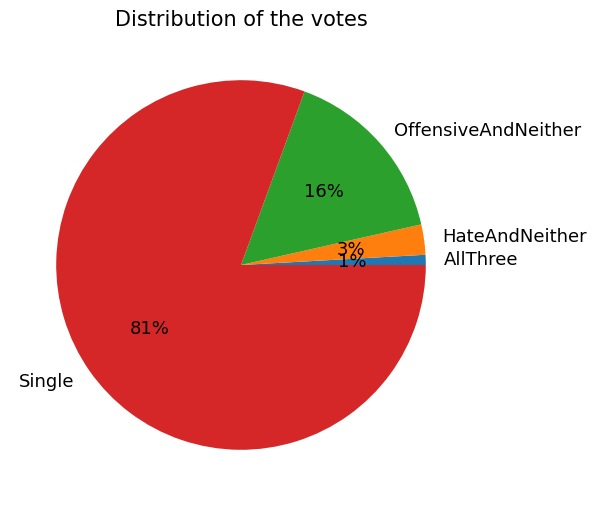

In [272]:
# Create a df from fp dictionary
df_distributions = pd.DataFrame(distributions)


# Plot a pie chart of the classess by using labels from label_dict
df_distributions['label'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%', figsize=(10, 6), fontsize=13)


# Label the pie chart
plt.ylabel('')
plt.title('Distribution of the votes', fontsize=15)


# Save the plot into slike folder
plt.savefig('./slike/distribution-votes.png')

In [284]:
# Print the amount of cases that are not labeled 'AllThree'
print(f"Amount of cases that are not labeled 'Single': {len(df_distributions[df_distributions['label'] == 'Single'])}")


Amount of cases that are not labeled 'Single': 274
